In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
torchvision.__version__

cuda:0


'0.16.0+cu121'

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


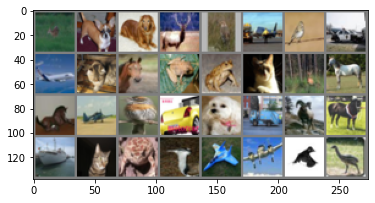

deer  dog   dog   deer  bird  plane bird  car   plane cat   horse frog  frog  cat   deer  horse horse plane bird  car   dog   truck deer  horse ship  cat   frog  bird  plane plane bird  bird 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 52),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(52, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


net = Net()
net.to(device)


Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
softmax = nn.Softmax(dim=1)

In [6]:
correct_train = 0
total_train = 0

for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    running_acc = 0.0
    iter_inbatch = 0  # Iteration in batch

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        net.to(device)
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        # calcuate an objective loss 
        loss = criterion(outputs, labels)
        
        # get probabilites of each label
        proba = softmax(outputs).cpu().detach().numpy()
        # get predicted label
        pred_labels = [np.argmax(i) for i in proba]
        pred_labels = np.array(pred_labels)

        
        # Calculated accuracy 
        correct = 0
        accuracy = 0
        
        # allocate label to cpu
        gt_labels = labels.cpu().detach().numpy()

        for p ,g in zip(pred_labels,gt_labels):

            if p == g:
                correct+=1

        acc = 100 * (correct/len(gt_labels))

        # backprop and optmizer update weight
        loss.backward()
        optimizer.step()
        running_acc +=acc 
        running_loss +=loss.item()
        iter_inbatch +=1
            
            
        print("Training Epochs : {} , Loss : {} , Acc : {} ".format(epoch,(running_loss/iter_inbatch), (running_acc/iter_inbatch)))

        # get loss in current epoch
        train_loss = running_loss/iter_inbatch # calculate a mean loss (total loss / iteration)
        train_acc = running_acc/iter_inbatch

Training Epochs : 0 , Loss : 2.3099288940429688 , Acc : 12.5 
Training Epochs : 0 , Loss : 2.3117175102233887 , Acc : 14.0625 
Training Epochs : 0 , Loss : 2.308310031890869 , Acc : 11.458333333333334 
Training Epochs : 0 , Loss : 2.304041564464569 , Acc : 10.15625 
Training Epochs : 0 , Loss : 2.3011294841766357 , Acc : 11.875 
Training Epochs : 0 , Loss : 2.301183501879374 , Acc : 11.458333333333334 
Training Epochs : 0 , Loss : 2.2998691967555454 , Acc : 11.160714285714286 
Training Epochs : 0 , Loss : 2.3004919588565826 , Acc : 10.15625 
Training Epochs : 0 , Loss : 2.3003266122606068 , Acc : 10.416666666666666 
Training Epochs : 0 , Loss : 2.302598237991333 , Acc : 10.3125 
Training Epochs : 0 , Loss : 2.302159396084872 , Acc : 10.511363636363637 
Training Epochs : 0 , Loss : 2.3025043606758118 , Acc : 10.9375 
Training Epochs : 0 , Loss : 2.3043692845564623 , Acc : 10.576923076923077 
Training Epochs : 0 , Loss : 2.3030734402792796 , Acc : 10.9375 
Training Epochs : 0 , Loss : 2.

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
net = Net()
net.to(device)

net.load_state_dict(torch.load(PATH))
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')